In [ ]:
!pip install shap
!pip install pandas==1.2.0
!pip install --upgrade xlrd
!pip install --upgrade pandas
!pip install nfl_data_py
!pip install imbalanced-learn
!pip install nflfastpy
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.2.0-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires pandas>=1.3, but you have pandas 1.2.0 which is incompatible.
fastparquet 2022.12.0 requires pandas>=1.5.0, but you have pandas 1.2.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.5.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.0
    Uninstalling pandas-1.2.0:
      Successfully uninstalled pandas-1.2.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Install and Import Necessary Packages

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import plotly.graph_objects as go
import nfl_data_py as nfl
#import nflfastpy as nfl

# ML models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/BetAIData/

/content/drive/MyDrive/BetAIData


## Organize Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get file names to upload
dir_idx: str = "/content/drive/MyDrive/BetAIData/2000.xls"
df = pd.read_excel(dir_idx)
features: list = ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Round', 'Best of', 
                  'Winner', "Loser", 'Surface', 'WRank', 'LRank', "Wsets", 'Lsets', "Comment"]              
df = df[features]

for i in tqdm(range(2001, 2023)): 
  if i < 2013: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xls"
  else: 
    dir_idx: str = f"/content/drive/MyDrive/BetAIData/{i}.xlsx"
  
  df_add = pd.read_excel(dir_idx)
  df_add = df_add[features]
  df = pd.concat([df, df_add])

 55%|█████▍    | 12/22 [00:03<00:03,  3.11it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 59%|█████▉    | 13/22 [00:05<00:05,  1.63it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 64%|██████▎   | 14/22 [00:06<00:06,  1.16it/s]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
 68%|██████▊   | 15/22 [00:07<00:07,  1.00s/it]/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
100%|██████████| 22/22 [00:16<00:00,  1.35it/s]


In [ ]:
df = df[df['Comment'] == 'Completed']

## Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61296 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         61296 non-null  int64         
 1   Location    61296 non-null  object        
 2   Tournament  61296 non-null  object        
 3   Date        61296 non-null  datetime64[ns]
 4   Series      61296 non-null  object        
 5   Court       61296 non-null  object        
 6   Round       61296 non-null  object        
 7   Best of     61281 non-null  float64       
 8   Winner      61296 non-null  object        
 9   Loser       61296 non-null  object        
 10  Surface     61296 non-null  object        
 11  WRank       61276 non-null  object        
 12  LRank       61191 non-null  object        
 13  Wsets       61008 non-null  float64       
 14  Lsets       61006 non-null  float64       
 15  Comment     61296 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
df['Best of'].value_counts()

3.0    49642
5.0    11639
Name: Best of, dtype: int64

<ipython-input-56-dc239bdebb06>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_tbl = df.corr()


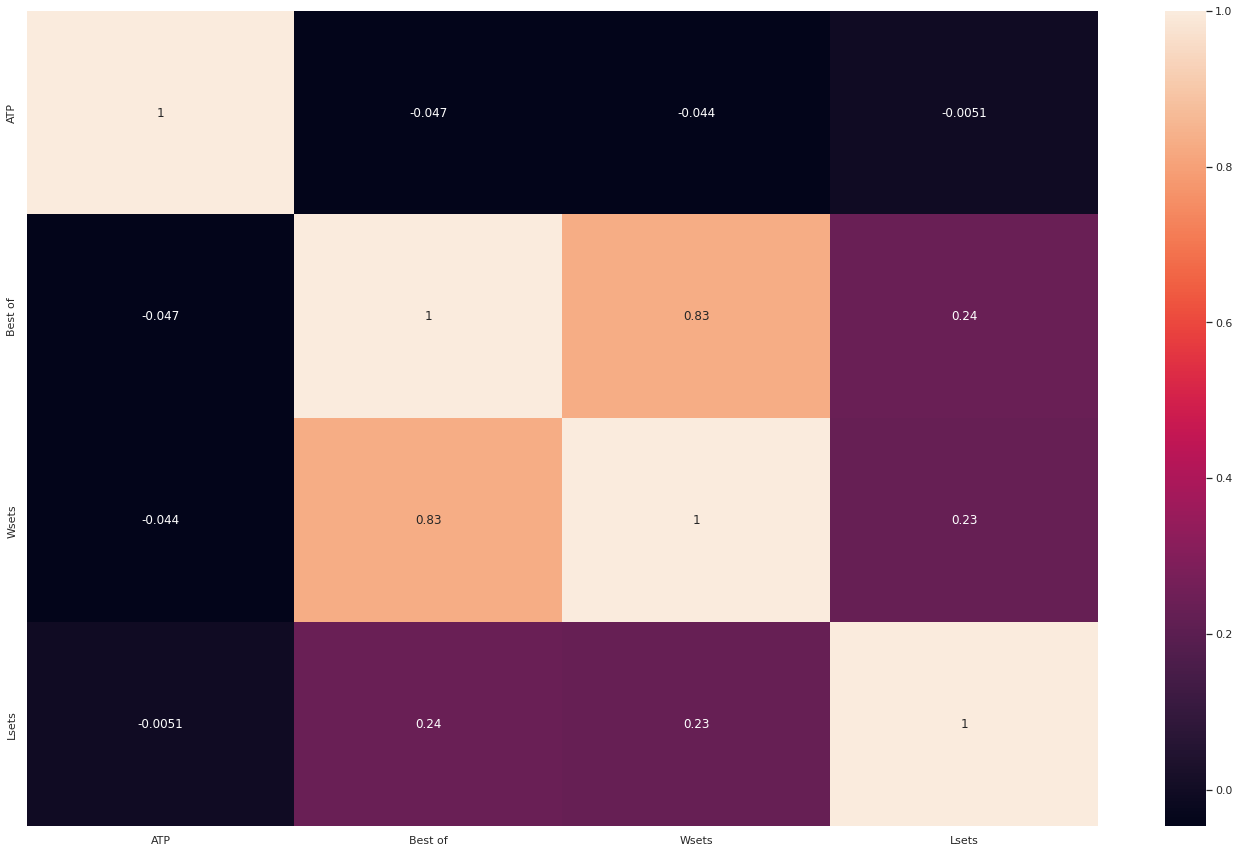

In [ ]:
# find feature correlations
corr_tbl = df.corr()

sns.set(rc={'figure.figsize':(24,15)})
sns.heatmap(corr_tbl, annot=True)

## Data Preprocessing

In [ ]:
# remove correlated columns automatically
corr_df = df.corr()

# get all items above 0.5 correlation and drop them from dataframe 
try: 
  df.drop(['score','tourney_name','winner_name',
                      'loser_name','minutes', 'l_1stIn', 'l_1stWon', 'l_2ndWon','l_ace', 'l_svpt',
                      'l_SvGms','l_bpFaced','l_df', 'l_bpSaved',  'w_1stIn', 'w_1stWon','w_2ndWon', 'w_SvGms',
                      'w_ace', 'w_svpt','w_bpFaced', 'w_bpSaved','w_df'], axis=1, inplace=True)
except KeyError: 
  pass
  
df.info()

<ipython-input-362-3a2fb4903ef4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59081 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         59081 non-null  int64         
 1   Location    59081 non-null  object        
 2   Tournament  59081 non-null  object        
 3   Date        59081 non-null  datetime64[ns]
 4   Series      59081 non-null  object        
 5   Court       59081 non-null  object        
 6   Round       59081 non-null  object        
 7   Best of     59066 non-null  float64       
 8   Winner      59081 non-null  object        
 9   Loser       59081 non-null  object        
 10  Surface     59081 non-null  object        
 11  WRank       59061 non-null  object        
 12  LRank       58979 non-null  object        
 13  Wsets       59080 non-null  float64       
 14  Lsets       59080 non-null  float64       
 15  Comment     59081 non-null  object        
dtypes: datetime64[ns](1), f

In [ ]:
# check nan values
df.isnull().sum()
length = df.shape[0]
nan_prev_threshold: float = 85

null_df = df.isnull().sum()
for col in df.columns:
  null_df[f'{col}_percent'] = (null_df[col]/length)*100
null_df.drop(df.columns, inplace=True)

null_df_refined = pd.DataFrame(columns=['feature', 'nan_prevalence'])
null_df_refined['feature'] = null_df.index
null_df_refined['nan_prevalence'] = null_df.values
null_df_refined = null_df_refined[null_df_refined['nan_prevalence'] < nan_prev_threshold]
null_df_refined.reset_index(inplace=True, drop=True)
features: list = list(null_df_refined['feature'])
features = [col.replace('_percent', '') for col in features]

In [ ]:
df = df[features]
df.shape

(59081, 16)

## Feature Engineering

## Run Once

In [ ]:
try: 
  df.drop(['Date', 'Comment'], inplace=True, axis=1)
except KeyError: 
  pass

In [ ]:
# remove nans from sets
df = df[~df['Wsets'].isna()]
df = df[~df['Lsets'].isna()]

In [ ]:
df = df[df['Wsets'] != 'NR']
df = df[df['Lsets'] != 'NR']
df = df[df['LRank'] != 'NR']
df = df[df['WRank'] != 'NR']

In [ ]:
df['target_w'] = df['Wsets']
df['target_l'] = df['Lsets']

## Variable Encoding

In [ ]:
# encoding for tournament
tourn_encoder = LabelEncoder()
df['Tournament'] = tourn_encoder.fit_transform(df['Tournament'].astype(str))

# encoder for location
loc_encoder = LabelEncoder()
df['Location'] = loc_encoder.fit_transform(df['Location'].astype(str))

# series encoder
ser_encoder = LabelEncoder()
df['Series'] = ser_encoder.fit_transform(df['Series'].astype(str))

# court encoder
court_encoder = LabelEncoder()
df['Court'] = court_encoder.fit_transform(df['Court'].astype(str))

# round encoder
round_encoder = LabelEncoder()
df['Round'] = round_encoder.fit_transform(df['Round'].astype(str))

# surface encoder
surf_encoder = LabelEncoder()
df['Surface'] = surf_encoder.fit_transform(df['Surface'].astype(str))

# winner and loser encoder
winner_encoder = LabelEncoder()
df['Winner'] = winner_encoder.fit_transform(df['Winner'].astype(str))
loser_encoder = LabelEncoder()
df['Loser'] = loser_encoder.fit_transform(df['Loser'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59054 entries, 0 to 2631
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         59054 non-null  int64  
 1   Location    59054 non-null  int64  
 2   Tournament  59054 non-null  int64  
 3   Series      59054 non-null  int64  
 4   Court       59054 non-null  int64  
 5   Round       59054 non-null  int64  
 6   Best of     59039 non-null  float64
 7   Winner      59054 non-null  int64  
 8   Loser       59054 non-null  int64  
 9   Surface     59054 non-null  int64  
 10  WRank       59034 non-null  object 
 11  LRank       58952 non-null  object 
 12  Wsets       59054 non-null  float64
 13  Lsets       59054 non-null  float64
 14  target_w    59054 non-null  float64
 15  target_l    59054 non-null  float64
dtypes: float64(5), int64(9), object(2)
memory usage: 7.7+ MB


In [ ]:
# imputer handling nan values
df_imputed = pd.DataFrame(SimpleImputer(strategy='most_frequent').fit_transform(df))
df_imputed.columns = df.columns
df_imputed.index = df.index
df = df_imputed.copy()  
df['target_w'] = df['target_w'].astype(int)
df['target_l'] = df['target_l'].astype(int)

## Updated Game-by-Game Model

In [ ]:
from pprint import pprint 
df = nfl.import_pbp_data([i for i in range(1999, 2023)])

1999 done.
2000 done.
2001 done.


In [ ]:
#df[['home_team', 'away_team', 'total_home_score', 'total_away_score']][:50]
from tqdm import tqdm 
features: list = ['home_team', 'away_team', 'weather', 'surface', 'stadium', 
                  'week', 'home_wp', 'away_wp', 'location', 'total', 'away_score', 'home_score', 
                  'home_coach', 'away_coach']

def temperature(weather_report):
    try: 
      example = weather_report.split('Temp: ')[1]
      example = float(example.split('°')[0])
      example
      return example
    except (ValueError, IndexError): 
      return np.nan

def humidity(weather_report): 
  try: 
    example = weather_report.split('Humidity: ')[1]
    example = float(example.split('%')[0])
    return example 
  except (ValueError, IndexError): 
    return np.nan

refined_df = pd.DataFrame([], columns=features)

for game_id in tqdm(df['game_id'].unique()): 
  temp_df = df[df['game_id'] == game_id][features].tail(1)
  refined_df = pd.concat([refined_df, temp_df])

#refined_df['temp'] = refined_df['weather'].apply(lambda x: temperature(str(x)))
#refined_df['humidity'] = refined_df['weather'].apply(lambda x: humidity(str(x)))
#refined_df.drop('weather', axis=1, inplace=True)
try: 
  refined_df.drop(['temp', 'humidity'], axis=1, inplace=True)
except KeyError: 
  pass

In [ ]:
refined_df.drop(['location'], axis=1, inplace=True)

In [ ]:
refined_df.drop('weather', axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = refined_df

team_arr: list = []
team_arr.extend(list(df['away_team']))
team_arr.extend(list(df['home_team']))

home_enc = LabelEncoder()
home_enc.fit(team_arr)
df['away_team'] = home_enc.transform(df['away_team'])
df['home_team'] = home_enc.transform(df['home_team'])

df['total_score'] = df['home_score'] + df['away_score']

In [ ]:
coach_arr: list = []
coach_arr.extend(list(df['away_coach']))
coach_arr.extend(list(df['home_coach']))

coach_enc = LabelEncoder()
coach_enc.fit(coach_arr)
df['away_coach'] = coach_enc.transform(df['away_coach'])
df['home_coach'] = coach_enc.transform(df['home_coach'])

stad_enc = LabelEncoder()
df['stadium'] = stad_enc.fit_transform(df['stadium'])

In [ ]:
df['Target'] = df["total_score"] > 50
df['Target'] = df['Target'].astype(int)

In [ ]:
df.drop('surface', axis=1, inplace=True)

In [ ]:
df['total_score'] = df['total_score'].astype(int)
df['week'] = df['week'].astype(int)
df['total'] = df['total'].astype(int)
df['away_score'] = df['away_score'].astype(int)
df['home_score'] = df['home_score'].astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score

df.dropna(inplace=True)
X = df.drop(['Target', 'away_score', 'home_score', 'total_score', 'total'], axis=1)
y = df[['Target']]

# oversample with SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.1, stratify=y)

model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
print(scores)
model.fit(X_train, y_train)
preds = model.predict(X_test)
roc_auc_score(preds, y_test)

<BarContainer object of 8 artists>

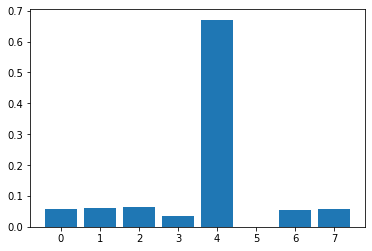

In [ ]:
import matplotlib.pyplot as plt 
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [ ]:
probs_pred = model.predict_proba(X_test)
confidence = 0.92

correct, incorrect, skipped = 0, 0, 0

for arr_prob, actual in zip(probs_pred, y_test.values): 
  prob = arr_prob[np.argmax(arr_prob)]
  pred = np.argmax(arr_prob)

  if prob > confidence: 
    if pred == actual[0]: 
      correct += 1
    else: 
      incorrect += 1
  else: 
    skipped += 1

print(correct / (incorrect + correct))
print(skipped / len(y_test))

0.9777777777777777
0.8946135831381733


In [ ]:
# live usage
X

,home_team,away_team,stadium,week,home_wp,away_wp,home_coach,away_coach
0,28,1,1,1,1.000000,0.000000,105,20
1,20,4,86,1,0.000000,1.000000,28,39
2,2,5,105,1,1.000000,0.000000,11,29
3,11,10,62,1,1.000000,0.000000,86,69
4,24,13,77,1,0.000000,1.000000,42,53
...,...,...,...,...,...,...,...,...
4261,0,3,128,4,0.151072,0.848928,66,101
4262,16,27,111,16,0.018884,0.981116,70,77
4263,11,11,7,15,0.614330,0.385670,51,44
4264,7,26,8,15,1.000000,0.000000,83,37
